# Project 3 

In [1]:
import pandas as pd
import random
from datetime import datetime
import numpy as np
import time 
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

## Problem 1 

In [2]:
#Clustering problem formulation. 
"""
For this clustering problem, I will be defining four new features (based on some of the current features of data) that will serve
as high level descriptors of a user's reviews/prescence on yelp:
1. "Persona" - Yelp Community's perception of the person's personality. Combination of compliments (hot,profile,cute,cool)
2. "Prose" - " " perception of the person's writing style. Combination of comments (funny, cool) and compliments (plain,funny
photos). Since comments are more passive then compliments, comments will be weighted appropriately to reflect this.
3. "Informative" - " " perception of how informative a user is. Combination of comments (useful) and compliments (list,write,more,photos)
4. Activity/Consistency - user's rate of activity. review_counts/(current_year - yelping_since) - in days

These four traits will be used in addition to user_id and elite as the basis vectors for clustering
"""

#Import yelp data
yelp_data = pd.read_csv("yelp.csv")

In [3]:
# Data Preprocessing
compliment_weight = 2
data_len = len(yelp_data['user_id'])
yelping_days = np.zeros(data_len)
elite_counts_1 = np.zeros(data_len)
#create vector for days active for user, create conversion from elite years to # of elite years
for i in range(data_len):
    yelping_days[i] = abs((datetime.strptime('2018-11-13', "%Y-%m-%d") - datetime.strptime(yelp_data['yelping_since'][i], "%Y-%m-%d")).days)
    if yelp_data['elite'][i] == 'None':
        elite_counts_1[i] = 0
    else:
        elite_counts_1[i] = len(yelp_data['elite'][i].split(','))
        
yelp_data = yelp_data.assign(persona_score = compliment_weight*(yelp_data['compliment_hot']+yelp_data['compliment_profile']+yelp_data['compliment_cute']+yelp_data['compliment_cool']) /4)
yelp_data = yelp_data.assign(prose_score = (compliment_weight*(yelp_data['compliment_plain']+yelp_data['compliment_funny']+0.5*yelp_data['compliment_photos']+yelp_data['compliment_cool']) + yelp_data['funny'] + yelp_data['useful']) /5)
yelp_data = yelp_data.assign(inform_score = (compliment_weight*(yelp_data['compliment_list']+yelp_data['compliment_writer']+0.5*yelp_data['compliment_photos'] + yelp_data['compliment_more']) + yelp_data['useful'])/5)
yelp_data = yelp_data.assign(yelping_since_conv = yelping_days)
yelp_data = yelp_data.assign(consistency_score = (yelp_data['review_count']/yelp_data['yelping_since_conv']))
yelp_data = yelp_data.assign(elite_counts = elite_counts_1)
yelp_data.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,fans,elite,average_stars,...,compliment_cool,compliment_funny,compliment_writer,compliment_photos,persona_score,prose_score,inform_score,yelping_since_conv,consistency_score,elite_counts
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,0,0,0,0,None,3.70,...,0,0,0,0,0.0,0.0,0.0,1876.0,0.005330,0.0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,0,0,0,0,None,2.00,...,0,0,0,0,0.0,0.0,0.0,621.0,0.001610,0.0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,0,0,0,0,None,4.67,...,0,0,0,0,0.0,0.0,0.0,1341.0,0.004474,0.0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,0,0,0,0,None,4.67,...,0,0,0,0,0.0,0.0,0.0,796.0,0.003769,0.0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,4,0,0,0,None,3.45,...,0,0,1,0,0.0,0.8,1.2,2311.0,0.004760,0.0


In [4]:
yelp_data_conv1 = yelp_data[['elite_counts','persona_score','prose_score','inform_score','consistency_score']]
#Data to be used for rest of project will be under total_data variable
total_data = yelp_data_conv1.values
yelp_data_conv1.head()

,elite_counts,persona_score,prose_score,inform_score,consistency_score
0,0.0,0.0,0.0,0.0,0.005330
1,0.0,0.0,0.0,0.0,0.001610
2,0.0,0.0,0.0,0.0,0.004474
3,0.0,0.0,0.0,0.0,0.003769
4,0.0,0.0,0.8,1.2,0.004760


## Problem 2 

In [99]:
#Online K-means - parameters K, min_batch_size, iterations

K_list = [3,5,10,20,50]
min_batch_size_list = [10,50,100,500]
iterations = 25

#Set iterations to 25, do sweep to find optimum for K/min_batch_size in terms of avg_distance
avg_dist_matrix = np.zeros([len(K_list), len(min_batch_size_list)])


k_idx = 0
print('start')
for K in K_list:
    r_idx = 0
    for min_batch_size in min_batch_size_list:
        #Initialize centroids
        #choose K random data points as centroid start points 
        centroids_list = []
        min_batch_data_centroid_assign = min_batch_size*[0]
        min_batch_centroid_data_assign = [[] for i in range(K)]
        K_centroids_starts = [random.randrange(data_len) for i in range(K)]
        
        #keep centroid vectors in list of numpy arrays - excluding user_id
        for centroid in K_centroids_starts:
            centroids_list.append(total_data[centroid,:])
            

        for iters in range(iterations):
            iters = iters + 1              
            prev_centroids_list = [centroids_list[i] for i in range(len(centroids_list))]
            min_batch_idx = [random.randrange(data_len) for t in range(min_batch_size)]
            #assign datapoints, then adjust centroids until stopping condition
            
            #assign datapoints
            for idx_num in range(min_batch_size):
                min_value = np.inf
                diff = centroids_list - total_data[min_batch_idx[idx_num],:]
                diff_in = np.diagonal(np.inner(diff,diff))
                min_batch_data_centroid_assign[idx_num] = np.argmin(diff_in)    
                min_batch_centroid_data_assign[min_batch_data_centroid_assign[idx_num]].append(idx_num)
            
            avg_dist_overall = 0        
            #update centroids  
            for i in range(min_batch_size):
                assigned_centroid_idx = min_batch_data_centroid_assign[i]
                data_point = total_data[min_batch_idx[i],:]
                assigned_centroid = centroids_list[assigned_centroid_idx]
                centroids_list[assigned_centroid_idx] = assigned_centroid + (1/iters)*(data_point - assigned_centroid)
            
            
        for i in range(K):
            data_assigns = min_batch_centroid_data_assign[i]
            assign_len = len(data_assigns)
                
            if not assign_len:
                avg_dist_matrix[k_idx,r_idx] = np.inf
            else:
                run_dist = 0
                for j in range(assign_len):
                    true_idx = min_batch_idx[data_assigns[j]]
                    data = total_data[true_idx,:]
                    dist = np.inner(data-centroids_list[i],data-centroids_list[i])
                    run_dist = run_dist + (1/assign_len)*dist
                avg_dist_matrix[k_idx,r_idx] = run_dist
        r_idx = r_idx + 1
        print('K:',K,'min_batch_size:',min_batch_size,'iters:',iters)
        
    k_idx = k_idx + 1
        
        
     

start
K: 3 min_batch_size: 10 iters: 25
K: 3 min_batch_size: 50 iters: 25
K: 3 min_batch_size: 100 iters: 25
K: 3 min_batch_size: 500 iters: 25
K: 5 min_batch_size: 10 iters: 25
K: 5 min_batch_size: 50 iters: 25
K: 5 min_batch_size: 100 iters: 25
K: 5 min_batch_size: 500 iters: 25
K: 10 min_batch_size: 10 iters: 25
K: 10 min_batch_size: 50 iters: 25
K: 10 min_batch_size: 100 iters: 25
K: 10 min_batch_size: 500 iters: 25
K: 20 min_batch_size: 10 iters: 25
K: 20 min_batch_size: 50 iters: 25
K: 20 min_batch_size: 100 iters: 25
K: 20 min_batch_size: 500 iters: 25
K: 50 min_batch_size: 10 iters: 25
K: 50 min_batch_size: 50 iters: 25
K: 50 min_batch_size: 100 iters: 25
K: 50 min_batch_size: 500 iters: 25


In [100]:
print(avg_dist_matrix)

#looks like min is K=10, min_batch_size = 10

[[6.11357541e+02 1.07406013e+04 2.93577541e+06 4.39273209e+03]
 [2.51233364e+05 7.14033189e+03 1.86865157e+06 2.40956082e+04]
 [8.05829239e-01 4.17921994e+01 1.03833242e+03 7.33140053e+03]
 [5.78066199e+02 5.52701501e+01 1.51466699e+05 5.71348908e+01]
 [6.96526225e+02 1.31035440e+00 2.09812985e+01 1.65823164e+02]]


In [150]:
#Online K-means - parameters K, min_batch_size, iterations

K = 20
min_batch_size= 10
iterations_list = [5,10,15,20,25,50,100]

#Sweep iterations
avg_dist_matrix = np.zeros([len(iterations_list), 1])


i_idx = 0
print('start')
for iterations in iterations_list:
    #Initialize centroids
    #choose K random data points as centroid start points 
    centroids_list = []
    min_batch_data_centroid_assign = min_batch_size*[0]
    min_batch_centroid_data_assign = [[] for i in range(K)]
    K_centroids_starts = [random.randrange(data_len) for i in range(K)]
        
    #keep centroid vectors in list of numpy arrays - excluding user_id
    for centroid in K_centroids_starts:
        centroids_list.append(total_data[centroid,:])
            

    for iters in range(iterations):
        iters = iters + 1              
        prev_centroids_list = [centroids_list[i] for i in range(len(centroids_list))]
        min_batch_idx = [random.randrange(data_len) for t in range(min_batch_size)]
        #assign datapoints, then adjust centroids until stopping condition
            
        #assign datapoints
        for idx_num in range(min_batch_size):
            min_value = np.inf
            diff = centroids_list - total_data[min_batch_idx[idx_num],:]
            diff_in = np.diagonal(np.inner(diff,diff))
            min_batch_data_centroid_assign[idx_num] = np.argmin(diff_in)    
            min_batch_centroid_data_assign[min_batch_data_centroid_assign[idx_num]].append(idx_num)
            
        avg_dist_overall = 0        
        #update centroids  
        for i in range(min_batch_size):
            assigned_centroid_idx = min_batch_data_centroid_assign[i]
            data_point = total_data[min_batch_idx[i],:]
            assigned_centroid = centroids_list[assigned_centroid_idx]
            centroids_list[assigned_centroid_idx] = assigned_centroid + (1/iters)*(data_point - assigned_centroid)
            
            
        for i in range(K):
            data_assigns = min_batch_centroid_data_assign[i]
            assign_len = len(data_assigns)
                
            run_dist = 0
            for j in range(assign_len):
                true_idx = min_batch_idx[data_assigns[j]]
                data = total_data[true_idx,:]
                dist = np.inner(data-centroids_list[i],data-centroids_list[i])
                run_dist = run_dist + (1/assign_len)*dist
            avg_dist_matrix[i_idx] = run_dist
    i_idx = i_idx + 1
    print('iters:',iters)

        
        
     

start
iters: 5
iters: 10
iters: 15
iters: 20
iters: 25
iters: 50
iters: 100


In [151]:
print(avg_dist_matrix)
#best avg iterations is 20

[[9.12507653e+00]
 [3.22316638e-01]
 [3.52755512e+03]
 [3.71703569e+00]
 [5.33803041e-01]
 [9.10972537e+01]
 [3.24129325e-01]]


In [158]:
#Online K-means - parameters K, min_batch_size, epsilon (stopping criteria)

K_list = [3,5,10,20,50]
min_batch_size_list = [10,50,100,500]


#stopping criteria epsilon is minimum change in centroid position as percentage
stopping = 0.1

avg_dist_matrix = np.zeros([len(K_list), len(min_batch_size_list)])
k_idx = 0
print('start')
for K in K_list:
    r_idx = 0
    for min_batch_size in min_batch_size_list:
        #Initialize centroids
        #choose K random data points as centroid start points 
        centroids_list = []
        min_batch_data_centroid_assign = min_batch_size*[0]
        min_batch_centroid_data_assign = [[] for i in range(K)]
        K_centroids_starts = [random.randrange(data_len) for i in range(K)]
        
        #keep centroid vectors in list of numpy arrays - excluding user_id
        for centroid in K_centroids_starts:
            centroids_list.append(total_data[centroid,:])
            
        
        #stop_cond = K*[0]
        iters = 0
        
        #List of lists, where each element a is list that holds [data_points_in_cent,stopping]
        centroid_counts_stop= K *[[0,False]]
        while True:
            prev_centroids_list = [centroids_list[i] for i in range(len(centroids_list))]
            min_batch_idx = [random.randrange(data_len) for t in range(min_batch_size)]
            #assign datapoints, then adjust centroids until stopping condition
            iters = iters + 1
            #assign datapoints
            for idx_num in range(min_batch_size):
                min_value = np.inf
                for i in range(K):
                    diff = centroids_list[i] - total_data[min_batch_idx[idx_num],:]
                    diff_in = np.inner(diff,diff)
                    
                    if diff_in < min_value:
                        min_batch_data_centroid_assign[idx_num] = i
                        min_value = diff_in
                
                min_batch_centroid_data_assign[min_batch_data_centroid_assign[idx_num]].append(idx_num)
            
            avg_dist_overall = 0        
            #update centroids  
            for i in range(min_batch_size):
                assigned_centroid_idx = min_batch_data_centroid_assign[i]
                
                
                if(not centroid_counts_stop[assigned_centroid_idx][1]):
                    data_point = total_data[min_batch_idx[i],:]
                    assigned_centroid = centroids_list[assigned_centroid_idx]
                    counts = centroid_counts_stop[assigned_centroid_idx][0] + 1
                    centroid_counts_stop[assigned_centroid_idx][0] = counts
                    eta = 1/counts
                
                    centroids_list[assigned_centroid_idx] = assigned_centroid + eta*(data_point - assigned_centroid)
            
            
            centroid_diff = [True if np.inner(abs(prev_centroids_list[i] - centroids_list[i]),abs(prev_centroids_list[i] - centroids_list[i])) < stopping*np.inner(abs(centroids_list[i]),abs(centroids_list[i])) else False for i in range(len(centroids_list))]
            if all(item for item in centroid_diff):
                break
                
        for i in range(K):
            centroid_counts_stop[i][1] = centroid_diff[i]
                
            data_assigns = min_batch_centroid_data_assign[i]
            assign_len = len(data_assigns)
                
            run_dist = 0
            for j in range(assign_len):
                true_idx = min_batch_idx[data_assigns[j]]
                data = total_data[true_idx,:]
                dist = np.inner(data-centroids_list[i],data-centroids_list[i])
                run_dist = run_dist + (1/assign_len)*dist
            avg_dist_matrix[k_idx,r_idx] = run_dist
            
        r_idx = r_idx + 1
        print('K:',K,'min_batch_size:',min_batch_size,'iters:',iters)
        
    k_idx = k_idx + 1
        
        
     

start
K: 3 min_batch_size: 10 iters: 4
K: 3 min_batch_size: 50 iters: 4
K: 3 min_batch_size: 100 iters: 3
K: 3 min_batch_size: 500 iters: 3
K: 5 min_batch_size: 10 iters: 4
K: 5 min_batch_size: 50 iters: 3
K: 5 min_batch_size: 100 iters: 2
K: 5 min_batch_size: 500 iters: 2
K: 10 min_batch_size: 10 iters: 2
K: 10 min_batch_size: 50 iters: 4
K: 10 min_batch_size: 100 iters: 6
K: 10 min_batch_size: 500 iters: 2
K: 20 min_batch_size: 10 iters: 3
K: 20 min_batch_size: 50 iters: 2
K: 20 min_batch_size: 100 iters: 2
K: 20 min_batch_size: 500 iters: 3
K: 50 min_batch_size: 10 iters: 2
K: 50 min_batch_size: 50 iters: 2
K: 50 min_batch_size: 100 iters: 1
K: 50 min_batch_size: 500 iters: 2


In [159]:
avg_dist_matrix
#best k = 20, min_batch = 10

array([[1.90095351e+02, 1.33940132e+01, 1.18052071e+03, 4.93141891e+03],
       [3.88986857e+00, 5.83461051e+02, 2.21150450e+01, 4.00702099e+01],
       [4.00001512e-01, 1.17258540e+00, 3.83452645e+03, 1.17776601e+05],
       [5.14600176e+01, 2.56239767e+00, 5.11166158e-05, 1.94801681e+01],
       [4.29477008e-10, 8.00153429e-02, 5.10130150e-09, 2.46438335e+01]])

## Problem 3 

In [14]:
# k-means++ with mini-batch- std
#K_list = [3,5,10,20,50]
K_list = [500]

start = time.time()
n = len(yelp_data['user_id'])
for K in K_list:        
        
    initial_centroid_idx = random.randrange(n)
    initial_centroid = total_data[initial_centroid_idx,:]
    centroids_list_k_plus_idx = []
    centroids_list_k_plus_idx.append(initial_centroid_idx)
    centroids_list_k_plus = []
    centroids_list_k_plus.append(initial_centroid)

    #Calculate distances
    dist = total_data - initial_centroid
    dist2 = np.linalg.norm(dist,axis=1)
    dist2_sum = sum(dist2)
    p_x = dist2/dist2_sum

    #choose next candidate point based off p(x)
    second_centroid_idx = np.random.choice(np.arange(n), p=p_x)
    second_centroid = total_data[second_centroid_idx,:]
    centroids_list_k_plus_idx.append(second_centroid_idx)
    centroids_list_k_plus.append(second_centroid)
        
    print('recursion start')
    success = k_means_seeding(dist2,second_centroid,K-2)
    end = time.time()
    if success == 1:
        print('Seeding complete. Its been ',(end-start)/60,' minutes')
            
    

recursion start
Seeding complete. Its been  6.948114077250163  minutes


In [13]:
def k_means_seeding(dist_centroid0, centroid1, K_remain):
    #print('Remaining K:', K_remain)
    if K_remain == 1: #last iteration= 
        dist_centroid1 = np.linalg.norm(total_data - centroid1,axis=1)
        p_x_list = [dist_centroid0[i] if dist_centroid0[i] < dist_centroid1[i] else dist_centroid1[i] for i in range(n)]
        p_x_sum = sum(p_x_list)
        p_x = p_x_list/p_x_sum
        
        #return next centroid idx
        next_centroid_idx = np.random.choice(np.arange(n), p=p_x)
        next_centroid = total_data[next_centroid_idx,:]
        
        centroids_list_k_plus.append(next_centroid)
        centroids_list_k_plus_idx.append(next_centroid_idx)
        return 1
    else:
        dist_centroid1 = np.linalg.norm(total_data - centroid1,axis=1)
        p_x_list = [dist_centroid0[i] if dist_centroid0[i] < dist_centroid1[i] else dist_centroid1[i] for i in range(n)]
        p_x_sum = sum(p_x_list)
        p_x = p_x_list/p_x_sum
        next_centroid_idx = np.random.choice(np.arange(n), p=p_x)
        next_centroid = total_data[next_centroid_idx,:]
        
        centroids_list_k_plus.append(next_centroid)
        centroids_list_k_plus_idx.append(next_centroid_idx)
        
        return k_means_seeding(dist_centroid1, next_centroid,K_remain-1)
    

## Problem 4 

In [25]:
#Run through for custom k-means seeding, seeing how long O(n) is when n is the length of the entire dataset

start = time.time()

init_seed_sum = np.array(5*[0])

init_seed_sum_list = [init_seed_sum+total_data[i,:] for i in range(n)]
end = time.time()

print('its been ',(end-start)/60, 'minutes to do single pass through data')

its been  4.688793587684631 minutes to do single pass through data


In [26]:
#it takes 4.6887 minutes to do a single pass with a running sum - so this cannot be the method to use

In [44]:
start1 = time.time()
random_idx = random.randrange(n)
first_centroid = [random_idx,:]

pairwaise_dist = [np.inner(first_centroid-total_data[i,:],first_centroid-total_data[i,:] for i in range(n)]

end1 = time.time()
print('its been ',(end1-start1)/60, 'minutes to do dist from one point over all dataset')

its been  9.661566265424092 minutes to do dist from one point over all dataset


In [58]:
#Custom seeding process main idea:
# n - size of dataset
# K - number of centroids to seed
# Process:
# - Initialize prev_centroids_dist = 0. prev_centroid_idx0 = prev_centroid_idx1 = 0
# - Initialize centroid_list= K*[0]
# - Initial centroid is random point
# - For K centroids:
# - If K = 0: (first/second centroid)
# - For gamma rounds:
#      - Create two subsets of (n/K) datapoints.
#      - Brute force search of points with farthest distances within the two subsets (point0, point1)
#      - If current_dist > prev_centroids_dist --> Set prev_centroids_dist = current_dist. prev_centroid_idx0 = point0
#        prev_centroid_idx1 = point1
# - set centroid_list[0] = point0, centroid_list[1] = point1
# - Else: (for rest of K-2 centroids)
#      - for Gamma rounds, create a random subsection of (n/K) datapoints and calculate distance from the K-1 centroids already determined
#      - save the one with farthest average distance from those points.

n = len(yelp_data['user_id'])
#K_list = [3,5,10,20,100]
#gamma_list = [5,10,50,100,500]
#K_list = [5,10,50,100,500]
K_list = [5]
min_batch_size_list = [10]
iterations = 20


avg_dist_matrix = np.zeros([len(K_list), 1])
min_dist_matrix = np.zeros([len(K_list), 1])
max_dist_matrix = np.zeros([len(K_list), 1])
gamma_list = [4]

prev_centroid_dist0 = 0
prev_centroid_idx0 = 0


initial_centroid_idx = random.randrange(n)
intial_centroid = total_data[initial_centroid_idx,1:6]

start = time.time()
k_idx = 0
for K in K_list:
    print('K:', K)
    centroids_list = []
    centroids_list_idx = K*[0]
    centroids_list_idx[0] = initial_centroid_idx
    centroids_list.append(initial_centroid)
    for gamma in gamma_list:
        #print('gamma:',gamma)
        for i in range(K-1):
            big_diff = 0
            big_diff_idx = 0
            prev_K = i+1 #number of prev. centroids determined
            for gam in range(gamma):
                random_subset0_idx = [random.randrange(n) for j in range(int(n/(10*K)))] 

                idx_count = 0
                for idx in random_subset0_idx:
                    idx_count = idx_count + 1
                    #compute average distances to previously determined centroids
                    run_sum = prev_K*[0]
                    prev_cent = np.array(centroids_list)
                    diff = prev_cent-total_data[idx,:]
                    run_sum = (1/prev_K)*np.diagonal(np.inner(diff,diff))
                    
                    cur_big_diff = np.max(run_sum)
                    if cur_big_diff > big_diff:
                        big_diff = cur_big_diff
                        big_diff_idx = idx
                
            centroids_list_idx[i+1] = big_diff_idx
            centroids_list.append(total_data[big_diff_idx,:])
       
    print('centroids determined. Whole dataset runthrough begins')
    #Now that centroids are determined, go through entire dataset and assign centroid
    total_data_centroid_assign = [np.argmin(np.diagonal(np.inner(centroids_list - total_data[i,:],centroids_list - total_data[k,:]))) for k in range(n)]
    #total_data_centroid_assign = n*[0]
    total_centroid_data_assign = [[] for i in range(K)]
    for i in range(n):
        #diff = centroids_list_k_plus - total_data[i,:]
        #diff_in = np.diagonal(np.inner(diff,diff))
        #min_arg = np.argmin(diff_in) 
        #total_data_centroid_assign[i] = min_arg   
        total_centroid_data_assign[total_data_centroid_assign[i]].append(i)
            
    print('centroids assigments determined. Analytics begins')
    for i in range(K):
        data_assigns = total_centroid_data_assign[i]
        assign_len = len(data_assigns)
                
        if not assign_len:
            avg_dist_matrix[k_idx] = np.inf #cluster had no data assignments. Highly penalize this
        else:
            run_dist = 0
            min_dist = np.inf
            max_dist = 0
            for j in range(assign_len):
                true_idx = data_assigns[j]
                data = total_data[true_idx,:]
                dist = np.inner(data-centroids_list[i],data-centroids_list[i])
                if dist > max_dist:
                    max_dist = dist
                elif dist < min_dist:
                    min_dist = dist
                run_dist = run_dist + (1/assign_len)*dist
            avg_dist_matrix[k_idx] = run_dist
            min_dist_matrix[k_idx] = min_dist
            max_dist_matrix[k_idx] = max_dist
    k_idx = k_idx + 1



K: 5
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins


In [61]:
max_dist_matrix

array([[2.2410111e+10]])

## Problem 5 

### Random Initialization - Iteration Method

In [118]:
#Online K-means - parameters K, min_batch_size, iterations
#using optimum min_batch_size and iterations from Problem 2

K_list = [5,10,50,100,500]

n = len(yelp_data['user_id'])
min_batch_size_list = [10]
iterations = 20

#Set iterations to 25, do sweep to find optimum for K/min_batch_size in terms of avg_distance
avg_dist_matrix = np.zeros([len(K_list), 1])
min_dist_matrix = np.zeros([len(K_list), 1])
max_dist_matrix = np.zeros([len(K_list), 1])


k_idx = 0
print('start')
for K in K_list:
    print('K:',K)
    for min_batch_size in min_batch_size_list:
        #Initialize centroids
        #choose K random data points as centroid start points 
        centroids_list = []
        min_batch_data_centroid_assign = min_batch_size*[0]
        min_batch_centroid_data_assign = [[] for i in range(K)]
        K_centroids_starts = [random.randrange(data_len) for i in range(K)]
        
        #keep centroid vectors in list of numpy arrays - excluding user_id
        for centroid in K_centroids_starts:
            centroids_list.append(total_data[centroid,:])
            

        for iters in range(iterations):
            iters = iters + 1              
            prev_centroids_list = [centroids_list[i] for i in range(len(centroids_list))]
            min_batch_idx = [random.randrange(data_len) for t in range(min_batch_size)]
            #assign datapoints, then adjust centroids until stopping condition
            
            #assign datapoints
            for idx_num in range(min_batch_size):
                min_value = np.inf
                diff = centroids_list - total_data[min_batch_idx[idx_num],:]
                diff_in = np.diagonal(np.inner(diff,diff))
                min_batch_data_centroid_assign[idx_num] = np.argmin(diff_in)    
                min_batch_centroid_data_assign[min_batch_data_centroid_assign[idx_num]].append(idx_num)
            
            avg_dist_overall = 0        
            #update centroids  
            for i in range(min_batch_size):
                assigned_centroid_idx = min_batch_data_centroid_assign[i]
                data_point = total_data[min_batch_idx[i],:]
                assigned_centroid = centroids_list[assigned_centroid_idx]
                centroids_list[assigned_centroid_idx] = assigned_centroid + (1/iters)*(data_point - assigned_centroid)
            
          
        print('centroids determined. Whole dataset runthrough begins')
        #Now that centroids are determined, go through entire dataset and assign centroid
        total_data_centroid_assign = [np.argmin(np.diagonal(np.inner(centroids_list - total_data[i,:],centroids_list - total_data[k,:]))) for k in range(n)]
        #total_data_centroid_assign = n*[0]
        total_centroid_data_assign = [[] for i in range(K)]
        for i in range(n):
            #diff = centroids_list_k_plus - total_data[i,:]
            #diff_in = np.diagonal(np.inner(diff,diff))
            #min_arg = np.argmin(diff_in) 
            #total_data_centroid_assign[i] = min_arg   
            total_centroid_data_assign[total_data_centroid_assign[i]].append(i)
            
        print('centroids assigments determined. Analytics begins')
        for i in range(K):
            data_assigns = total_centroid_data_assign[i]
            assign_len = len(data_assigns)
                
            if not assign_len:
                run_dist = 0 #cluster had no data assignments. Highly penalize this
            else:
                run_dist = 0
                min_dist = np.inf
                max_dist = 0
                for j in range(assign_len):
                    true_idx = data_assigns[j]
                    data = total_data[true_idx,:]
                    dist = np.inner(data-centroids_list[i],data-centroids_list[i])
                    if dist > max_dist:
                        max_dist = dist
                    if dist < min_dist:
                        min_dist = dist
                    run_dist = run_dist + (1/assign_len)*dist
                avg_dist_matrix[k_idx] = avg_dist_matrix[k_idx] + (1/K_list[k_idx])*run_dist
                min_dist_matrix[k_idx] = min_dist
                max_dist_matrix[k_idx] = max_dist
    k_idx = k_idx + 1
        
        
     

start
K: 5
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 10
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 50
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 100
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 500
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins


In [119]:
avg_dist_matrix

array([[2088152.48741117],
       [2568280.61476066],
       [4880049.38713482],
       [1405195.2606312 ],
       [ 151356.14295568]])

In [120]:
min_dist_matrix

array([[4.26995069e+02],
       [2.86696355e+01],
       [2.50000000e-02],
       [1.60000000e-01],
       [5.40882743e-05]])

In [121]:
max_dist_matrix

array([[2.23857006e+10],
       [3.21983305e+05],
       [2.55671151e+01],
       [9.61450576e+00],
       [1.41005581e+00]])

Text(0.5,1,'Random Initialization (Set Iterations) Seeding Method')

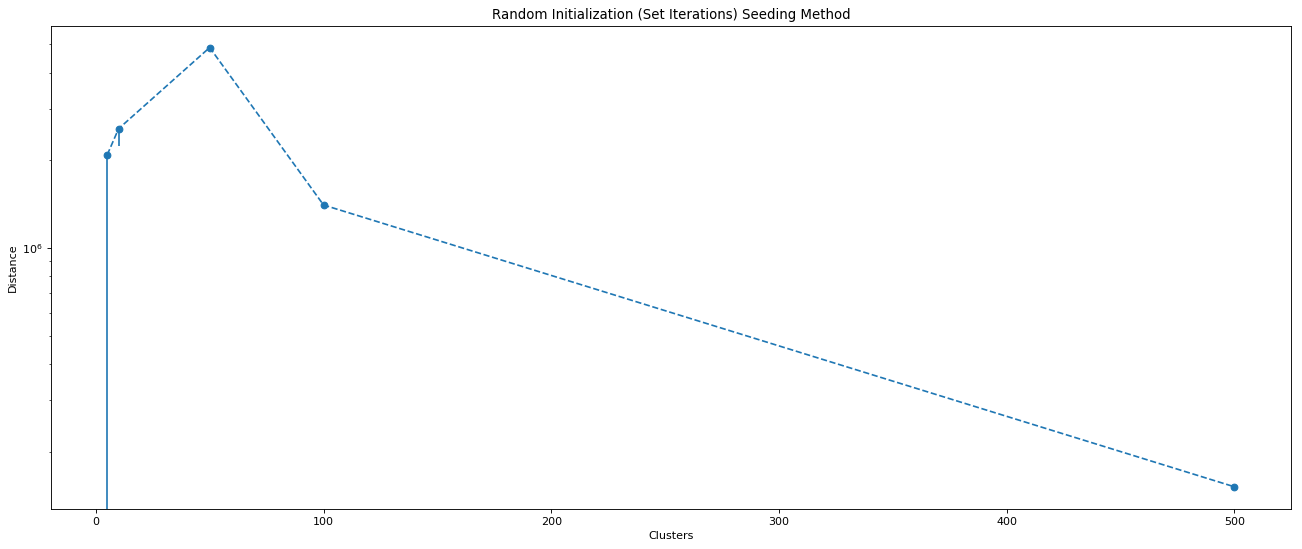

In [172]:
min_dist_matrix = [np.nan if min_dist_matrix[i] == np.inf else min_dist_matrix[i] for i in range(len(min_dist_matrix))]
max_dist_matrix = [np.nan if max_dist_matrix[i] == 0 else max_dist_matrix[i] for i in range(len(max_dist_matrix))]
yerr1 = [max_dist_matrix,min_dist_matrix]

x = [5,10,50,100,500]
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.yscale("log")
plt.errorbar(x,avg_dist_matrix,yerr=[max_dist_matrix,min_dist_matrix],fmt='--o')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.title('Random Initialization (Set Iterations) Seeding Method')

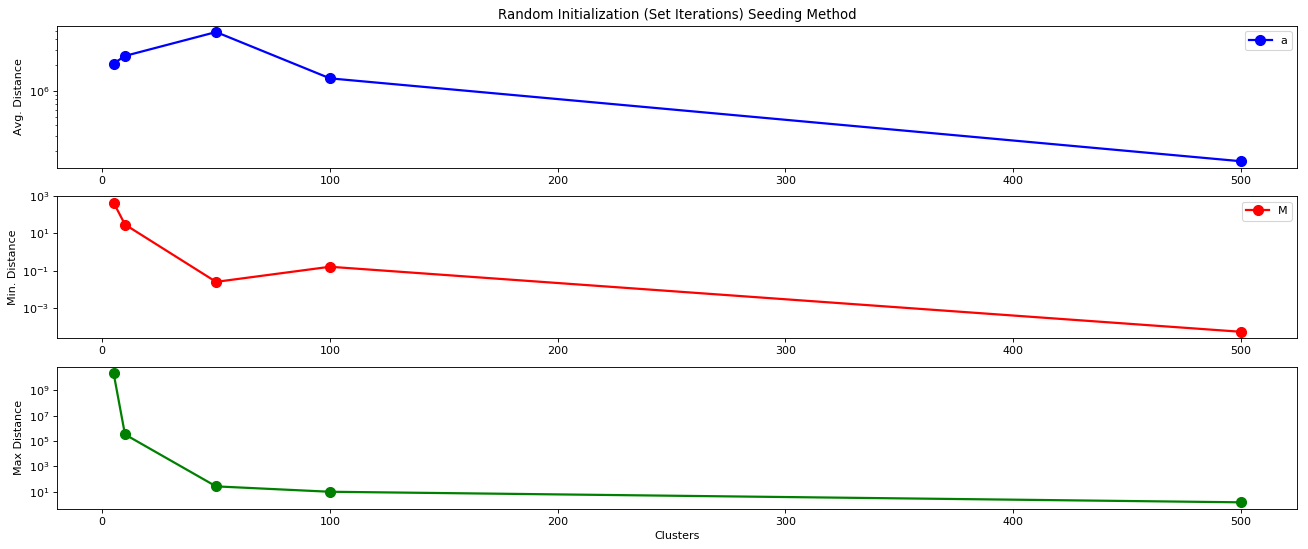

In [171]:
min_dist_matrix = [np.nan if min_dist_matrix[i] == np.inf else min_dist_matrix[i] for i in range(len(min_dist_matrix))]
max_dist_matrix = [np.nan if max_dist_matrix[i] == 0 else max_dist_matrix[i] for i in range(len(max_dist_matrix))]

x = [5,10,50,100,500]
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.semilogy( x,avg_dist_matrix, marker='o', markerfacecolor='blue', markersize=9, color='blue', linewidth=2)
plt.legend('avg distance')
plt.ylabel('Avg. Distance')
plt.title('Random Initialization (Set Iterations) Seeding Method')
plt.subplot(3, 1, 2)
plt.semilogy( x,min_dist_matrix, marker='o', markerfacecolor='red', markersize=9, color='red', linewidth=2)
plt.legend('Min Distance')
plt.ylabel('Min. Distance')
plt.subplot(3, 1, 3)
plt.semilogy( x,max_dist_matrix, marker='o', markerfacecolor='green', markersize=9, color='green', linewidth=2)
plt.xlabel('Clusters')
plt.ylabel('Max Distance')
plt.show()

### Random Initialization - Stopping Criterion

In [136]:
#Online K-means - parameters K, min_batch_size, epsilon (stopping criteria)
K_list = [5,10,50,100,500]
n = len(yelp_data['user_id'])
min_batch_size_list = [10]


#stopping criteria epsilon is minimum change in centroid position as percentage
stopping = 0.1

avg_dist_matrix0 = np.zeros([len(K_list), 1])
min_dist_matrix0 = np.zeros([len(K_list), 1])
max_dist_matrix0 = np.zeros([len(K_list), 1])
k_idx = 0
print('start')
for K in K_list:
    print('K:',K)
    for min_batch_size in min_batch_size_list:
        #Initialize centroids
        #choose K random data points as centroid start points 
        centroids_list = []
        min_batch_data_centroid_assign = min_batch_size*[0]
        min_batch_centroid_data_assign = [[] for i in range(K)]
        K_centroids_starts = [random.randrange(data_len) for i in range(K)]
        
        #keep centroid vectors in list of numpy arrays - excluding user_id
        for centroid in K_centroids_starts:
            centroids_list.append(total_data[centroid,:])
            
        
        #stop_cond = K*[0]
        iters = 0
        
        #List of lists, where each element a is list that holds [data_points_in_cent,stopping]
        centroid_counts_stop= K *[[0,False]]
        while True:
            prev_centroids_list = [centroids_list[i] for i in range(len(centroids_list))]
            min_batch_idx = [random.randrange(data_len) for t in range(min_batch_size)]
            #assign datapoints, then adjust centroids until stopping condition
            iters = iters + 1
            #assign datapoints
            for idx_num in range(min_batch_size):
                min_value = np.inf
                for i in range(K):
                    diff = centroids_list[i] - total_data[min_batch_idx[idx_num],:]
                    diff_in = np.inner(diff,diff)
                    
                    if diff_in < min_value:
                        min_batch_data_centroid_assign[idx_num] = i
                        min_value = diff_in
                
                min_batch_centroid_data_assign[min_batch_data_centroid_assign[idx_num]].append(idx_num)
            
            avg_dist_overall = 0        
            #update centroids  
            for i in range(min_batch_size):
                assigned_centroid_idx = min_batch_data_centroid_assign[i]
                
                
                if(not centroid_counts_stop[assigned_centroid_idx][1]):
                    data_point = total_data[min_batch_idx[i],:]
                    assigned_centroid = centroids_list[assigned_centroid_idx]
                    counts = centroid_counts_stop[assigned_centroid_idx][0] + 1
                    centroid_counts_stop[assigned_centroid_idx][0] = counts
                    eta = 1/counts
                
                    centroids_list[assigned_centroid_idx] = assigned_centroid + eta*(data_point - assigned_centroid)
            
            
            centroid_diff = [True if np.inner(abs(prev_centroids_list[i] - centroids_list[i]),abs(prev_centroids_list[i] - centroids_list[i])) < stopping*np.inner(abs(centroids_list[i]),abs(centroids_list[i])) else False for i in range(len(centroids_list))]
            if all(item for item in centroid_diff):
                break
            elif iters > 20:
                print('hard stop on interations')
                break
                
        print('centroids determined. Whole dataset runthrough begins')
        #Now that centroids are determined, go through entire dataset and assign centroid
        total_data_centroid_assign = [np.argmin(np.diagonal(np.inner(centroids_list - total_data[i,:],centroids_list - total_data[k,:]))) for k in range(n)]
        #total_data_centroid_assign = n*[0]
        total_centroid_data_assign = [[] for i in range(K)]
        for i in range(n):
            #diff = centroids_list_k_plus - total_data[i,:]
            #diff_in = np.diagonal(np.inner(diff,diff))
            #min_arg = np.argmin(diff_in) 
            #total_data_centroid_assign[i] = min_arg   
            total_centroid_data_assign[total_data_centroid_assign[i]].append(i)
            
        print('centroids assigments determined. Analytics begins')
        for i in range(K):
            data_assigns = total_centroid_data_assign[i]
            assign_len = len(data_assigns)
                
            if not assign_len:
                run_dist = 0 #cluster had no data assignments. Highly penalize this
            else:
                run_dist = 0
                min_dist = np.inf
                max_dist = 0
                for j in range(assign_len):
                    true_idx = data_assigns[j]
                    data = total_data[true_idx,:]
                    dist = np.inner(data-centroids_list[i],data-centroids_list[i])
                    if dist > max_dist:
                        max_dist = dist
                    if dist < min_dist:
                        min_dist = dist
                    run_dist = run_dist + (1/assign_len)*dist
                avg_dist_matrix0[k_idx] = avg_dist_matrix0[k_idx] + (1/K_list[k_idx])*run_dist
                min_dist_matrix0[k_idx] = min_dist
                max_dist_matrix0[k_idx] = max_dist
        
    print('K:',K)
    k_idx = k_idx + 1
        

start
K: 5
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 5
K: 10
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 10
K: 50
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 50
K: 100
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 100
K: 500
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 500


In [137]:
avg_dist_matrix0

array([[2520442.9795957 ],
       [ 428946.1200318 ],
       [2098187.88763783],
       [ 111055.59739938],
       [ 110004.62786929]])

In [138]:
min_dist_matrix0

array([[2.60853721e-02],
       [3.92789534e-07],
       [3.32604013e-07],
       [2.72000000e+00],
       [1.88374882e-05]])

In [139]:
max_dist_matrix0

array([[ 9.373973  ],
       [ 4.04000964],
       [ 2.25000041],
       [32.28207911],
       [ 1.3300201 ]])

Text(0.5,1,'Random Initialization (Stopping Criterion) Seeding Method')

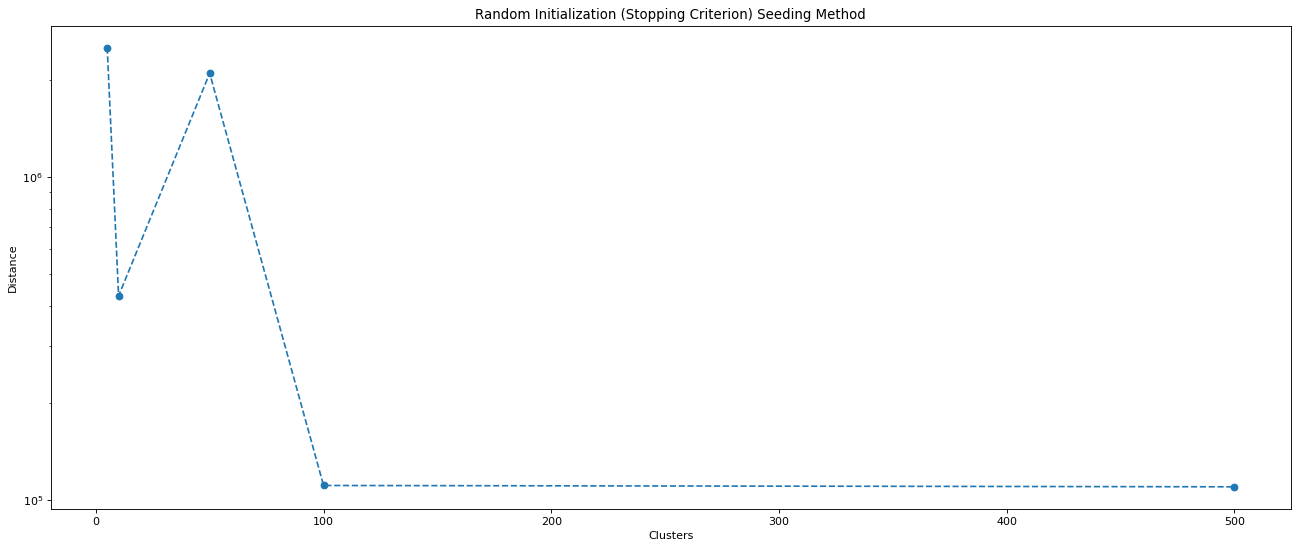

In [170]:
min_dist_matrix0 = [np.nan if min_dist_matrix0[i] == np.inf else min_dist_matrix0[i] for i in range(len(min_dist_matrix0))]
max_dist_matrix0 = [np.nan if max_dist_matrix0[i] == 0 else max_dist_matrix0[i] for i in range(len(max_dist_matrix0))]
yerr1 = [max_dist_matrix0,min_dist_matrix0]

x = [5,10,50,100,500]
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.yscale("log")
plt.errorbar(x,avg_dist_matrix0,yerr=[max_dist_matrix0,min_dist_matrix0],fmt='--o')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.title('Random Initialization (Stopping Criterion) Seeding Method')

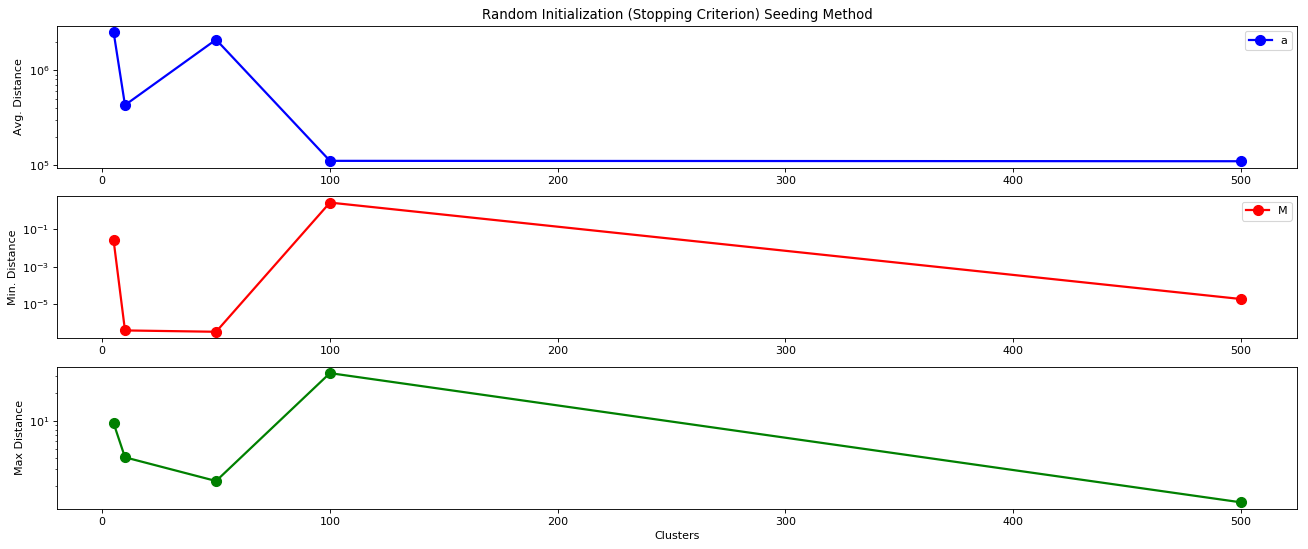

In [169]:
min_dist_matrix0 = [np.nan if min_dist_matrix0[i] == np.inf else min_dist_matrix0[i] for i in range(len(min_dist_matrix0))]
max_dist_matrix0 = [np.nan if max_dist_matrix0[i] == 0 else max_dist_matrix0[i] for i in range(len(max_dist_matrix0))]

x = [5,10,50,100,500]
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.semilogy( x,avg_dist_matrix0, marker='o', markerfacecolor='blue', markersize=9, color='blue', linewidth=2)
plt.legend('avg distance')
plt.ylabel('Avg. Distance')
plt.title('Random Initialization (Stopping Criterion) Seeding Method')
plt.subplot(3, 1, 2)
plt.semilogy( x,min_dist_matrix0, marker='o', markerfacecolor='red', markersize=9, color='red', linewidth=2)
plt.legend('Min Distance')
plt.ylabel('Min. Distance')
plt.subplot(3, 1, 3)
plt.semilogy( x,max_dist_matrix0, marker='o', markerfacecolor='green', markersize=9, color='green', linewidth=2)
plt.xlabel('Clusters')
plt.ylabel('Max Distance')
plt.show()

### K-Means++ 

In [124]:
# k-means++ with mini-batch- std
K_list = [5, 10, 50, 100, 500]
min_batch_size = 10
iterations = 20


avg_dist_matrix1 = np.zeros([len(K_list), 1])
min_dist_matrix1 = np.zeros([len(K_list), 1])
max_dist_matrix1 = np.zeros([len(K_list), 1])
k_idx = 0

start = time.time()
n = len(yelp_data['user_id'])
for K in K_list:        
        
    initial_centroid_idx = random.randrange(n)
    initial_centroid = total_data[initial_centroid_idx,:]
    centroids_list_k_plus_idx = []
    centroids_list_k_plus_idx.append(initial_centroid_idx)
    centroids_list_k_plus = []
    centroids_list_k_plus.append(initial_centroid)

    #Calculate distances
    dist = total_data - initial_centroid
    dist2 = np.linalg.norm(dist,axis=1)
    dist2_sum = sum(dist2)
    p_x = dist2/dist2_sum

    #choose next candidate point based off p(x)
    second_centroid_idx = np.random.choice(np.arange(n), p=p_x)
    second_centroid = total_data[second_centroid_idx,:]
    centroids_list_k_plus_idx.append(second_centroid_idx)
    centroids_list_k_plus.append(second_centroid)
        
    print('recursion start')
    success = k_means_seeding(dist2,second_centroid,K-2)
    end = time.time()
    if success == 1:
        print('Seeding complete. Its been ',(end-start)/60,' minutes')

            
    print('centroids determined. Whole dataset runthrough begins')
    #Now that centroids are determined, go through entire dataset and assign centroid
    total_data_centroid_assign = [np.argmin(np.diagonal(np.inner(centroids_list_k_plus - total_data[i,:],centroids_list_k_plus - total_data[k,:]))) for k in range(n)]
    #total_data_centroid_assign = n*[0]
    total_centroid_data_assign = [[] for i in range(K)]
    for i in range(n):
        #diff = centroids_list_k_plus - total_data[i,:]
        #diff_in = np.diagonal(np.inner(diff,diff))
        #min_arg = np.argmin(diff_in) 
        #total_data_centroid_assign[i] = min_arg   
        total_centroid_data_assign[total_data_centroid_assign[i]].append(i)
            
    print('centroids assigments determined. Analytics begins')
    for i in range(K):
        data_assigns = total_centroid_data_assign[i]
        assign_len = len(data_assigns)
                
        if not assign_len:
            run_dist = 0 #cluster had no data assignments. Highly penalize this
        else:
            run_dist = 0
            min_dist = np.inf
            max_dist = 0
            for j in range(assign_len):
                true_idx = data_assigns[j]
                data = total_data[true_idx,:]
                dist = np.inner(data-centroids_list_k_plus[i],data-centroids_list_k_plus[i])
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
                run_dist = run_dist + (1/assign_len)*dist
            avg_dist_matrix1[k_idx] = avg_dist_matrix1[k_idx] + (1/K_list[k_idx])*run_dist
            min_dist_matrix1[k_idx] = min_dist
            max_dist_matrix1[k_idx] = max_dist
    k_idx = k_idx + 1
    

recursion start
Seeding complete. Its been  0.03566236098607381  minutes
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
recursion start
Seeding complete. Its been  0.518856430053711  minutes
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
recursion start
Seeding complete. Its been  1.4777550498644512  minutes
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
recursion start
Seeding complete. Its been  3.7414450009663898  minutes
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
recursion start
Seeding complete. Its been  12.82253283659617  minutes
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins


In [125]:
avg_dist_matrix1

array([[4.08877304e+08],
       [9.66492067e+07],
       [1.69309350e+08],
       [1.25836792e+08],
       [4.95330573e+07]])

In [126]:
min_dist_matrix1

array([[   0.        ],
       [   0.        ],
       [4861.40392034],
       [7236.24485   ],
       [9346.93327318]])

In [127]:
max_dist_matrix1

array([[   5247.16011862],
       [   1616.00000001],
       [1455038.17157453],
       [  60046.92476807],
       [  42442.17946329]])

Text(0.5,1,'K-Means++ Seeding Method')

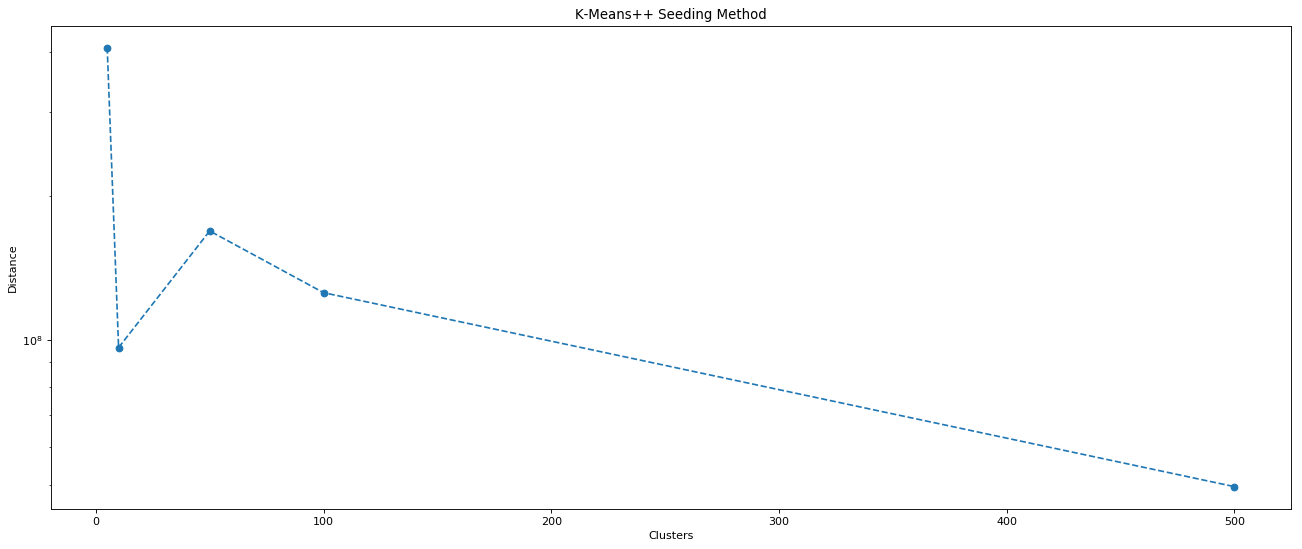

In [165]:
min_dist_matrix1 = [np.nan if min_dist_matrix1[i] == np.inf else min_dist_matrix1[i] for i in range(len(min_dist_matrix1))]
max_dist_matrix1 = [np.nan if max_dist_matrix1[i] == 0 else max_dist_matrix1[i] for i in range(len(max_dist_matrix1))]
yerr1 = [max_dist_matrix,min_dist_matrix]

x = [5, 10, 50, 100, 500]
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.yscale("log")
plt.errorbar(x,avg_dist_matrix1,yerr=[max_dist_matrix1,min_dist_matrix1],fmt='--o')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.title('K-Means++ Seeding Method')

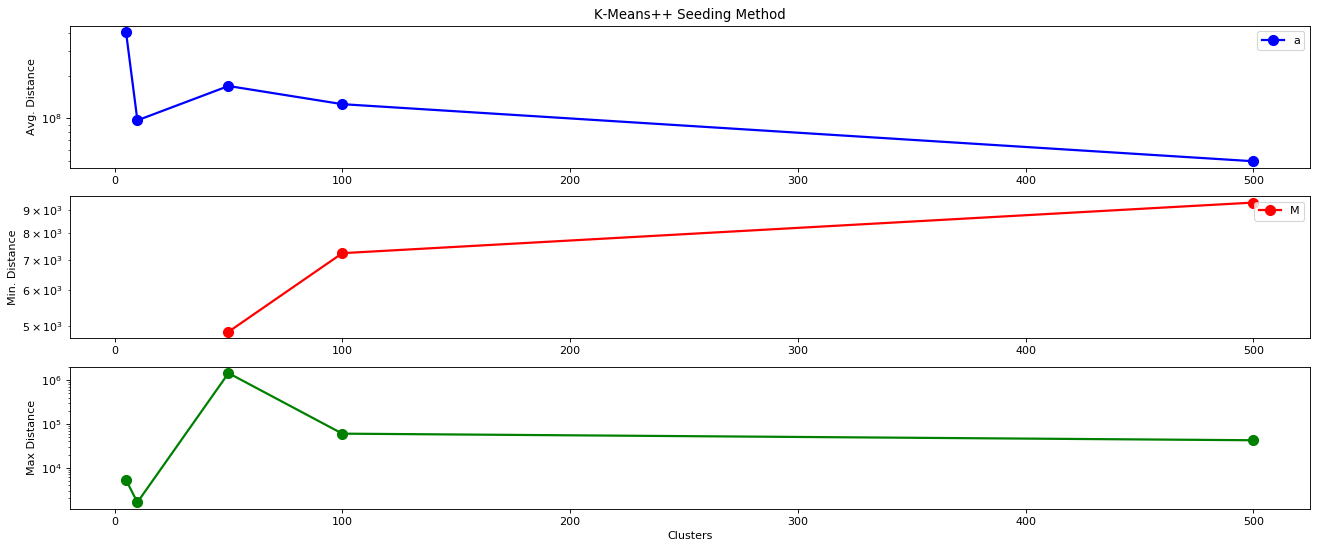

In [166]:
min_dist_matrix1 = [np.nan if min_dist_matrix1[i] == np.inf else min_dist_matrix1[i] for i in range(len(min_dist_matrix1))]
max_dist_matrix1 = [np.nan if max_dist_matrix1[i] == 0 else max_dist_matrix1[i] for i in range(len(max_dist_matrix1))]

x = [5, 10, 50, 100, 500]
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.semilogy( x,avg_dist_matrix1, marker='o', markerfacecolor='blue', markersize=9, color='blue', linewidth=2)
plt.legend('avg distance')
plt.ylabel('Avg. Distance')
plt.title('K-Means++ Seeding Method')
plt.subplot(3, 1, 2)
plt.semilogy( x,min_dist_matrix1, marker='o', markerfacecolor='red', markersize=9, color='red', linewidth=2)
plt.legend('Min Distance')
plt.ylabel('Min. Distance')
plt.subplot(3, 1, 3)
plt.semilogy( x,max_dist_matrix1, marker='o', markerfacecolor='green', markersize=9, color='green', linewidth=2)
plt.xlabel('Clusters')
plt.ylabel('Max Distance')
plt.show()

### Custom Method 

In [130]:
#Custom seeding process main idea:
# n - size of dataset
# K - number of centroids to seed
# Process:
# - Initialize prev_centroids_dist = 0. prev_centroid_idx0 = prev_centroid_idx1 = 0
# - Initialize centroid_list= K*[0]
# - Initial centroid is random point
# - For K centroids:
# - If K = 0: (first/second centroid)
# - For gamma rounds:
#      - Create two subsets of (n/K) datapoints.
#      - Brute force search of points with farthest distances within the two subsets (point0, point1)
#      - If current_dist > prev_centroids_dist --> Set prev_centroids_dist = current_dist. prev_centroid_idx0 = point0
#        prev_centroid_idx1 = point1
# - set centroid_list[0] = point0, centroid_list[1] = point1
# - Else: (for rest of K-2 centroids)
#      - for Gamma rounds, create a random subsection of (n/K) datapoints and calculate distance from the K-1 centroids already determined
#      - save the one with farthest average distance from those points.

n = len(yelp_data['user_id'])
#K_list = [3,5,10,20,100]
#gamma_list = [5,10,50,100,500]
K_list = [5,10,50,100,500]
min_batch_size_list = [10]
iterations = 20


avg_dist_matrix3 = np.zeros([len(K_list), 1])
min_dist_matrix3 = np.zeros([len(K_list), 1])
max_dist_matrix3 = np.zeros([len(K_list), 1])
gamma_list = [4]

prev_centroid_dist0 = 0
prev_centroid_idx0 = 0


initial_centroid_idx = random.randrange(n)
intial_centroid = total_data[initial_centroid_idx,1:6]

start = time.time()
k_idx = 0
for K in K_list:
    print('K:', K)
    centroids_list = []
    centroids_list_idx = K*[0]
    centroids_list_idx[0] = initial_centroid_idx
    centroids_list.append(initial_centroid)
    for gamma in gamma_list:
        #print('gamma:',gamma)
        for i in range(K-1):
            big_diff = 0
            big_diff_idx = 0
            prev_K = i+1 #number of prev. centroids determined
            for gam in range(gamma):
                #print('i:',i,'gam:',gam)
                random_subset0_idx = [random.randrange(n) for j in range(int(n/(10*K)))] 

                idx_count = 0
                for idx in random_subset0_idx:
                    idx_count = idx_count + 1
                    #compute average distances to previously determined centroids
                    run_sum = prev_K*[0]
                    
                    prev_cent = np.array(centroids_list)
                    diff = prev_cent-total_data[idx,:]
                    run_sum = run_sum + (1/prev_K)*np.diagonal(np.inner(diff,diff))
                    
                    cur_big_diff = np.max(run_sum)
                    if cur_big_diff > big_diff:
                        big_diff = cur_big_diff
                        big_diff_idx = idx
                
            centroids_list_idx[i+1] = big_diff_idx
            centroids_list.append(total_data[big_diff_idx,:])
       
    print('centroids determined. Whole dataset runthrough begins')
    #Now that centroids are determined, go through entire dataset and assign centroid
    total_data_centroid_assign = [np.argmin(np.diagonal(np.inner(centroids_list - total_data[i,:],centroids_list - total_data[k,:]))) for k in range(n)]
    #total_data_centroid_assign = n*[0]
    total_centroid_data_assign = [[] for i in range(K)]
    for i in range(n):
        #diff = centroids_list_k_plus - total_data[i,:]
        #diff_in = np.diagonal(np.inner(diff,diff))
        #min_arg = np.argmin(diff_in) 
        #total_data_centroid_assign[i] = min_arg   
        total_centroid_data_assign[total_data_centroid_assign[i]].append(i)
            
    print('centroids assigments determined. Analytics begins')
    for i in range(K):
        data_assigns = total_centroid_data_assign[i]
        assign_len = len(data_assigns)
                
        if not assign_len:
            run_dist = 0 #cluster had no data assignments. 
        else:
            run_dist = 0
            min_dist = np.inf
            max_dist = 0
            for j in range(assign_len):
                true_idx = data_assigns[j]
                if centroids_list_idx[i] == true_idx:
                    continue
                data = total_data[true_idx,:]
                dist = np.inner(data-centroids_list[i],data-centroids_list[i])
                
                if dist > max_dist:
                    max_dist = dist
                    
                if dist < min_dist:
                    min_dist = dist
                    
                run_dist = run_dist + (1/assign_len)*dist
            avg_dist_matrix3[k_idx] = avg_dist_matrix3[k_idx] + (1/K_list[k_idx])*run_dist
            min_dist_matrix3[k_idx] = min_dist
            max_dist_matrix3[k_idx] = max_dist
    k_idx = k_idx + 1



K: 5
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 10
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 50
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 100
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins
K: 500
centroids determined. Whole dataset runthrough begins
centroids assigments determined. Analytics begins


In [131]:
avg_dist_matrix3

array([[1.42035591e+09],
       [3.85021659e+08],
       [1.17908467e+08],
       [1.43093633e+08],
       [1.40594201e+07]])

In [132]:
min_dist_matrix3

array([[1.00658632e+09],
       [3.21271519e+09],
       [3.72861439e-03],
       [8.26555332e+09],
       [3.21271519e+09]])

In [133]:
max_dist_matrix3

array([[1.19140223e+10],
       [3.21271519e+09],
       [6.48060524e+07],
       [8.26555332e+09],
       [3.21271519e+09]])

Text(0.5,1,'Custom Seeding Method')

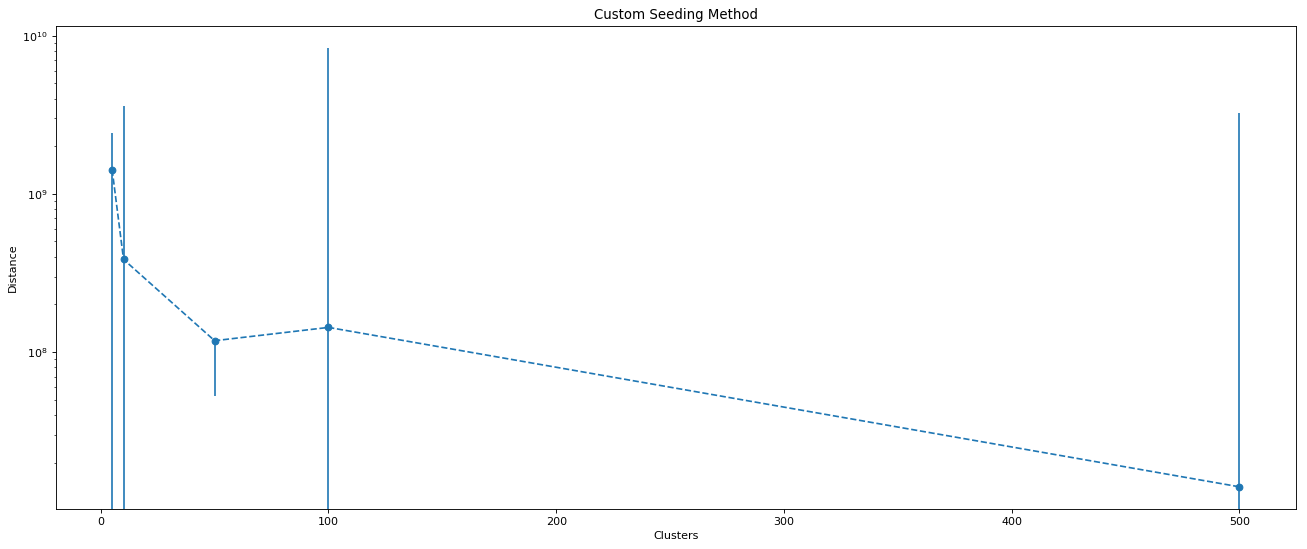

In [168]:
min_dist_matrix3 = [np.nan if min_dist_matrix3[i] == np.inf else min_dist_matrix3[i] for i in range(len(min_dist_matrix3))]
max_dist_matrix3 = [np.nan if max_dist_matrix3[i] == 0 else max_dist_matrix3[i] for i in range(len(max_dist_matrix3))]
yerr1 = [max_dist_matrix,min_dist_matrix]

x = [5,10,50,100,500]
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.yscale("log")
plt.errorbar(x,avg_dist_matrix3,yerr=[max_dist_matrix3,min_dist_matrix3],fmt='--o')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.title('Custom Seeding Method')

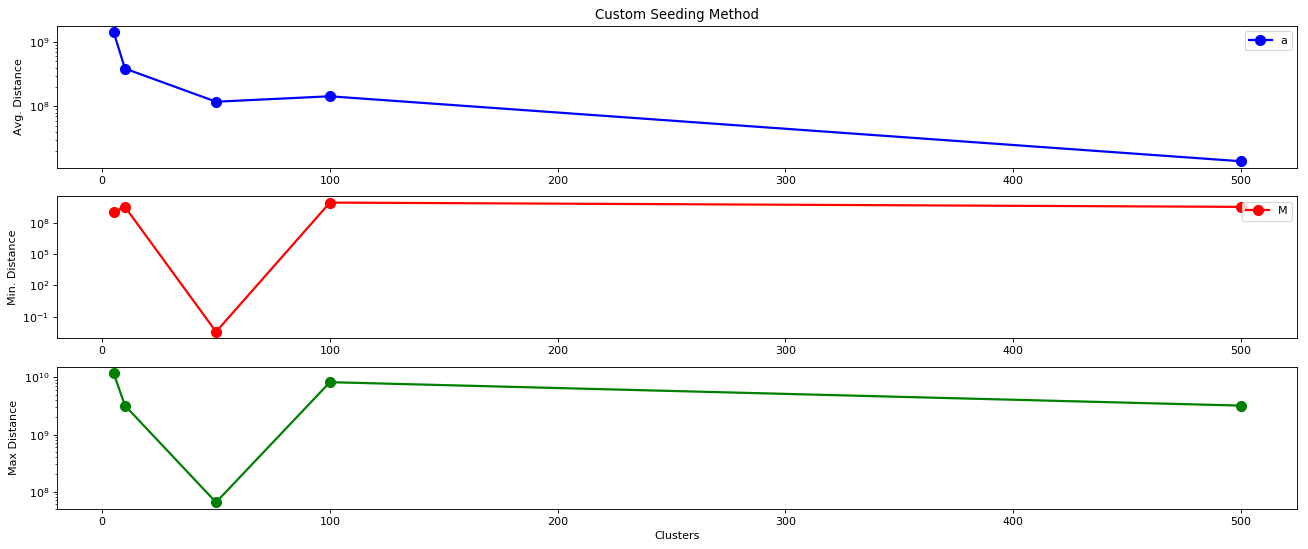

In [161]:
min_dist_matrix3 = [np.nan if min_dist_matrix3[i] == np.inf else min_dist_matrix3[i] for i in range(len(min_dist_matrix3))]
max_dist_matrix3 = [np.nan if max_dist_matrix3[i] == 0 else max_dist_matrix3[i] for i in range(len(max_dist_matrix3))]

x = [5,10,50,100,500]
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(3, 1, 1)
plt.semilogy( x,avg_dist_matrix3, marker='o', markerfacecolor='blue', markersize=9, color='blue', linewidth=2)
plt.legend('avg distance')
plt.ylabel('Avg. Distance')
plt.title('Custom Seeding Method')
plt.subplot(3, 1, 2)
plt.semilogy( x,min_dist_matrix3, marker='o', markerfacecolor='red', markersize=9, color='red', linewidth=2)
plt.legend('Min Distance')
plt.ylabel('Min. Distance')
plt.subplot(3, 1, 3)
plt.semilogy( x,max_dist_matrix3, marker='o', markerfacecolor='green', markersize=9, color='green', linewidth=2)
plt.xlabel('Clusters')
plt.ylabel('Max Distance')
plt.show()